In [21]:
import sqlite3 as sqlite
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

IMDB Database

In [3]:
db = 'im.db'
conn = sqlite.connect(db)
df = pd.read_sql("""SELECT 
                * 
            
            FROM movie_basics
                JOIN movie_ratings
                USING(movie_id)
            """, conn)

In [4]:
df.describe()

start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06

In [5]:
df.genres = df.genres.map(lambda x: x.split(',') if type(x) == str else x)

In [6]:
exploded_df_genres = df.explode('genres')
#describe of avg_rating of all movies
exploded_df_genres.averagerating.describe()

count    129294.000000
mean          6.303352
std           1.458034
min           1.000000
25%           5.400000
50%           6.400000
75%           7.300000
max          10.000000
Name: averagerating, dtype: float64

In [24]:
#Groupby dataset by genres and get means
genres_means = exploded_df_genres[exploded_df_genres.numvotes >= 50].groupby('genres').mean(numeric_only=True)
#describe of avg_rating of 'News'
news_rating = exploded_df_genres[exploded_df_genres.genres == 'News'].averagerating
news_rating.describe()

count    579.000000
mean       7.271330
std        0.999155
min        2.000000
25%        6.700000
50%        7.300000
75%        7.950000
max        9.400000
Name: averagerating, dtype: float64

## Ratings per Genre 

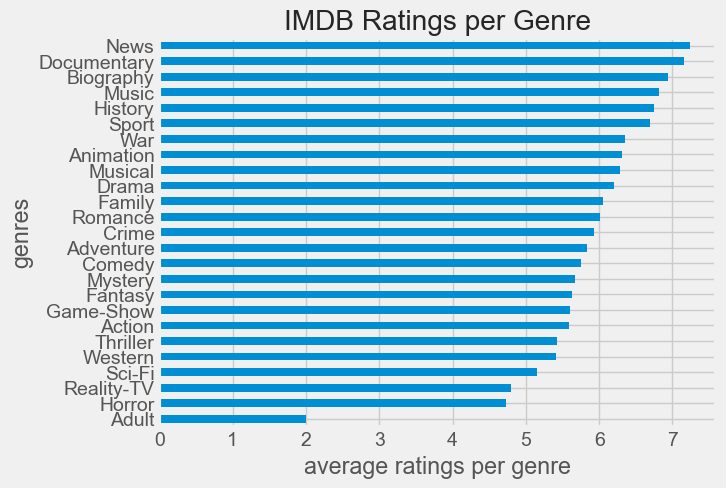

In [145]:
genres_means.averagerating.sort_values(ascending=True).plot(kind='barh',
                                                           xlabel = 'average ratings per genre',
                                                           title = 'IMDB Ratings per Genre');

In [11]:
#tn budgets dataset
budgets = pd.read_csv("zippedData/tn.movie_budgets.csv")

##  Joins tn movie budgets dataset with imdb movie basics dataset

In [12]:
#merge budgets with imdb
budget_join_imdb = budgets.merge(df, how='inner', left_on = 'movie', right_on = 'primary_title')

#turn strings into numbers
budget_join_imdb.production_budget = budget_join_imdb.production_budget.map(lambda x: int(x.strip("$").replace(',', '')))
budget_join_imdb.domestic_gross = budget_join_imdb.domestic_gross.map(lambda x: int(x.strip("$").replace(',', '')))
budget_join_imdb.worldwide_gross = budget_join_imdb.worldwide_gross.map(lambda x: int(x.strip("$").replace(',', '')))


Creates roi row.

roi = gross / budget

In [13]:
budget_join_imdb['roi'] = budget_join_imdb.worldwide_gross / budget_join_imdb.production_budget

Explodes each movie row by genre

In [39]:
exploded_roi = budget_join_imdb[['genres', 'roi', 'movie', 'averagerating']].explode('genres')
exploded_roi

genres       roi                                        movie  \
0        Horror  6.532577                                       Avatar   
1        Action  2.546673  Pirates of the Caribbean: On Stranger Tides   
1     Adventure  2.546673  Pirates of the Caribbean: On Stranger Tides   
1       Fantasy  2.546673  Pirates of the Caribbean: On Stranger Tides   
2        Action  0.427892                                 Dark Phoenix   
...         ...       ...                                          ...   
2873     Sci-Fi  0.000000                                       Red 11   
2873   Thriller  0.000000                                       Red 11   
2874      Drama  0.000000                         A Plague So Pleasant   
2874     Horror  0.000000                         A Plague So Pleasant   
2874   Thriller  0.000000                         A Plague So Pleasant   

      averagerating  
0               6.1  
1               6.6  
1               6.6  
1               6.6  
2               6.0  
...             ...  
2873            5.6  
2873            5.6  
2874            5.4  
2874            5.4  
2874            5.4  

[6452 rows x 4 columns]

## ROI bar chart 

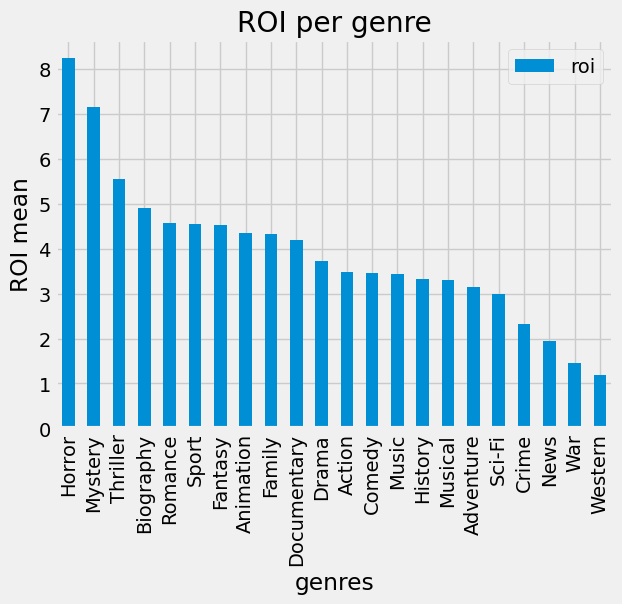

In [28]:
exploded_roi.groupby('genres').mean(numeric_only = True).sort_values(by = 'roi', ascending=False).plot(kind = 'bar',
                                                                                                      y = 'roi',
                                                                                                      ylabel = 'ROI mean',
                                                                                                      title = 'ROI per genre');

## Number of movies per genre with roi > 50 

In [29]:

exploded_roi[exploded_roi['roi'] > 50].genres.value_counts()

genres
Drama          15
Horror         10
Thriller        9
Romance         4
Mystery         4
Comedy          3
Sport           3
Action          3
Family          2
Fantasy         2
Biography       2
Crime           2
Documentary     2
Adventure       1
Animation       1
History         1
Name: count, dtype: int64

## Correlation between ROI and ratings by genre

/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


roi  averagerating
roi            1.000000      -0.484866
averagerating -0.484866       1.000000

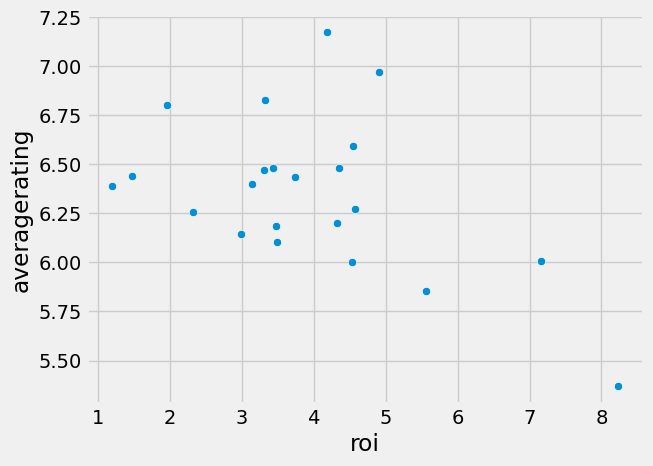

In [30]:
roi_rating_df = exploded_roi.groupby('genres').mean(numeric_only = True)
sns.scatterplot(data = roi_rating_df, x = 'roi', y = 'averagerating')
roi_rating_df.corr(numeric_only = True)

# Rotten Tomatoes review analysis 

In [31]:
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep = '\t', encoding = 'unicode_escape')

In [32]:
rt_info = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')

- Join reviews and info tables
- Find the count of fresh and rotten reviews by top critics

In [33]:
#Join tables
reviews_info_join = rt_reviews.merge(rt_info, how='left', left_on = 'id', right_on = 'id')
#Filter by top critics
reviews_info_join = reviews_info_join[reviews_info_join['top_critic'] == 1]
#Explode genres
reviews_info_join['genre'] = reviews_info_join['genre'].map(lambda x: x.split('|') if type(x) == str else x)
reviews_info_join = reviews_info_join.explode('genre')
#Fresh rotten table
fresh_rotten = reviews_info_join.groupby(['genre', 'fresh']).count()['id'] 

In [34]:
#Pivot table to get individual columns of fresh and rotten reviews
fresh_rotten = fresh_rotten.reset_index().pivot(columns='fresh', index = 'genre', values = 'id')

In [35]:
#fresh to rotten ratio column
fresh_rotten['fresh_to_rotten'] = fresh_rotten['fresh'] / fresh_rotten['rotten']

In [37]:
fresh_rotten = fresh_rotten.sort_values('fresh_to_rotten', ascending = False)
fresh_rotten

fresh                        fresh  rotten  fresh_to_rotten
genre                                                      
Gay and Lesbian                  9       2         4.500000
Documentary                    274      78         3.512821
Art House and International    910     309         2.944984
Sports and Fitness              60      23         2.608696
Classics                       275     113         2.433628
Cult Movies                      7       3         2.333333
Animation                      391     222         1.761261
Special Interest               162      98         1.653061
Drama                         5018    3291         1.524765
Musical and Performing Arts    355     235         1.510638
Romance                       1120     780         1.435897
Kids and Family                598     452         1.323009
Mystery and Suspense          1459    1271         1.147915
Comedy                        2828    2519         1.122668
Action and Adventure          1517    1381         1.098479
Faith and Spirituality          34      31         1.096774
Anime and Manga                  5       5         1.000000
Western                        144     146         0.986301
Science Fiction and Fantasy    754     798         0.944862
Television                      17      29         0.586207
Horror                         323     552         0.585145

## Fresh:Rotten ratio bar chart
Considering only top critics

/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


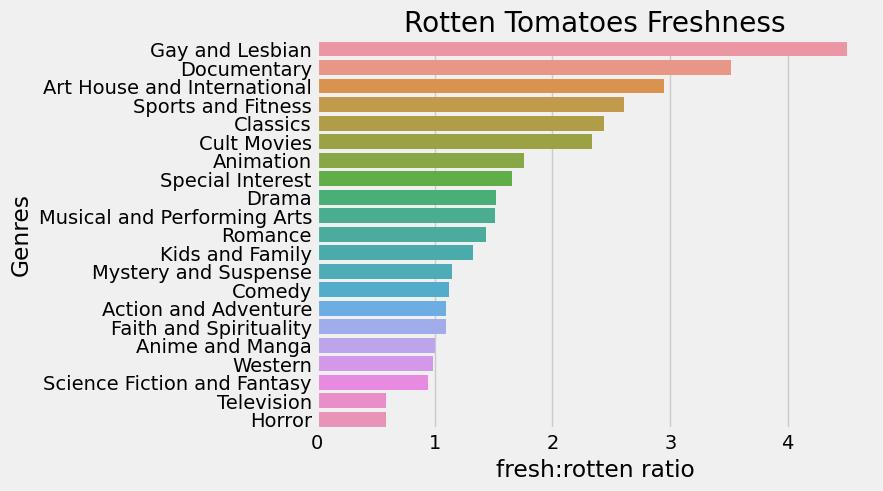

In [38]:
sns.barplot(data = fresh_rotten, y = fresh_rotten.index, x = 'fresh_to_rotten'). \
set(title='Rotten Tomatoes Freshness', xlabel = 'fresh:rotten ratio', ylabel = 'Genres');